In [1]:
# =============================================================================
# Import Libraries and functions
# =============================================================================
from Data_preparation import data_processing_with_BH_scaled
import numpy as np
import torch
import gpytorch
import os
from gpytorch.kernels import ProductKernel
import cloudpickle
from glob import glob
from scipy.special import eval_sh_legendre
from torch.optim import Adam
from gpytorch.kernels.keops import MaternKernel
from gpytorch.kernels import ScaleKernel, ProductKernel
from gpytorch.likelihoods.gaussian_likelihood import FixedNoiseGaussianLikelihood
from scipy.stats import entropy
import tqdm
import matplotlib.pyplot as plt
from torch import Tensor
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from botorch.models.utils.inducing_point_allocators import (GreedyVarianceReduction, 
                                                            InducingPointAllocator)
%matplotlib inline

cwd = os.getcwd()
plots_folder = cwd
# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

plots_folder = glob("..\\Plots\\")[0]
pickles_folder = glob("..\\Pickles\\")[0]

def Pickle_file(folder, filename, data):
    with open(folder + filename + '.pkl', mode='wb') as file:
        cloudpickle.dump(data, file)
        
def Unpickle_file(folder,filename):
    with open(folder+ filename + '.pkl', mode='rb') as file:
        data = cloudpickle.load(file)
    return data

plt.rcParams.update({'font.family':'sans','font.size': 7,
                     'font.weight':'regular','mathtext.default':'regular',
                    'legend.fontsize':7})    


# Load dataset - Data preparation
#### 1. Load data <small>(contains some hardcoding; CPT and BH data were organized together in an incomplete (containing nans) dataset (this is not neccessary was done to be used to another project).</small>
#### 2. split train/test data
#### 3. Standardize CPT data (lognormal distribution assumption)
#### 4. Prepare borehole data - Dir. based transformation

In [2]:
# =============================================================================
# Load data
# =============================================================================
dis_depth = 185
num_vertical_des_points = 438 
num_cpts_w_bhs = 30   # 5 bhs 

bh_ids = [0, 1, 12, 21, 27] 
num_bhs = 5 #training

data, xt, yt, zt, grid, \
    z_mat, mapping, Dxy, Dz, depth_0 = data_processing_with_BH_scaled(
        num_cpts_w_bhs, num_bhs, 
        dis_depth, 
        num_vertical_des_points,
        cpt_par = "Ic")

In [3]:
# Leave some cpts out for testing

ids = [i for i in range(data.shape[1])]
cpt_ids = [i for i in ids if i not in bh_ids]

data[:, [i for i in ids if i not in bh_ids]] = np.log(data[:, 
                                                           [i for i in ids if
                                                            i not in bh_ids]])   
depth_points = (grid[0] * (Dz - depth_0) + depth_0).numpy()

cpt_test_ids = [8, 16, 20, 24, 28]
excl_ids = [2, 13, 25, 26, 28]

data_test = data[:, cpt_test_ids]
data  = data[:, [i for i in ids if i not in cpt_test_ids+excl_ids]]

xt_test = xt[cpt_test_ids]
yt_test = yt[cpt_test_ids]

grid[1] = grid[1][[i for i in ids if i not in cpt_test_ids+excl_ids]]
grid[2] = grid[2][[i for i in ids if i not in cpt_test_ids+excl_ids]]

# -----------------------------------------------------------------------------
# some hardcoding
ids = [i for i in range(data.shape[1])]
bh_ids = [0, 1, 10, 16, 19]
cpt_ids = [i for i in ids if i not in bh_ids]


In [4]:
# create the train_x sets

data_cpts = data[:, cpt_ids]
y_nonnan_cpts = data_cpts.T.ravel()
y_nonnan_cpts = y_nonnan_cpts[~np.isnan(y_nonnan_cpts)]
len_nonnan_cpts = len(y_nonnan_cpts)
# create the train_x for cpts
depth_points = (grid[0] * (Dz - depth_0) + depth_0).numpy()

train_x_cpts = torch.zeros((len_nonnan_cpts, 3), dtype = torch.float64)
rowind = 0; 
for i, dat in enumerate(data_cpts.T):
    idni = len(dat[~np.isnan(dat)])

    train_x_cpts[rowind:rowind+idni, 0] = grid[0][:idni]
    train_x_cpts[rowind:rowind+idni, 1] = grid[1][cpt_ids[i]]
    train_x_cpts[rowind:rowind+idni, 2] = grid[2][cpt_ids[i]]
    rowind +=idni

In [5]:
# Same for boreholes

data_bhs = data[:, bh_ids]
y_nonnan_bhs = data_bhs.T.ravel()
y_nonnan_bhs = y_nonnan_bhs[~np.isnan(y_nonnan_bhs)]
len_nonnan_bhs = len(y_nonnan_bhs)
train_x_bhs = torch.zeros((len_nonnan_bhs, 3), dtype = torch.float64)
rowind = 0;
for i, dat in enumerate(data_bhs.T):
    idni = len(dat[~np.isnan(dat)])
    idni = len(dat[~np.isnan(dat)])
    train_x_bhs[rowind:rowind+idni, 0] = grid[0][:idni]
    train_x_bhs[rowind:rowind+idni, 1] = grid[1][bh_ids[i]]
    train_x_bhs[rowind:rowind+idni, 2] = grid[2][bh_ids[i]]
    rowind +=idni

In [6]:
# Standardize Ic data

mu_Ic = np.mean(np.exp(y_nonnan_cpts))
std_Ic = np.std(np.exp(y_nonnan_cpts))

def pars_log(mu_x,std_x):
    std_x_log = np.sqrt(np.log(std_x**2/mu_x**2 +1))
    mu_x_log = np.log(mu_x)-(std_x_log**2)/2    
    return mu_x_log,std_x_log

mu_Ic_log, std_Ic_log = pars_log(mu_Ic,std_Ic) 

In [7]:
# Prepare borehole data

y = data[:, bh_ids].copy().T.ravel()
y = y[~np.isnan(y)]
y_vec = y.astype(int)
y_discrete = torch.tensor(y_vec).long()
classes = np.unique(y_vec)
num_classes = len(classes)
Y = np.zeros((len(y_vec), len(classes)))
for i, e in enumerate(y_vec):
    # print(i, e)
    Y[i, np.where(classes == e)[0]] = 1
    
# label transformation
a_eps = 0.002    

s2_tilde = np.log(1.0 / (Y + a_eps) + 1)
Y_tilde = np.log(Y + a_eps) - 0.5 * s2_tilde

In [8]:
# merge the data
train_y = torch.cat([torch.tensor(Y_tilde, dtype = dtype).mT.ravel(), 
                       (torch.tensor(y_nonnan_cpts, dtype = dtype) - mu_Ic_log) / std_Ic_log], -1)

data_cpts_stdzd = (y_nonnan_cpts - mu_Ic_log) / std_Ic_log


mean_ytilde = np.mean(Y_tilde)
std_Y_tilde = np.std(Y_tilde)

data_Ic = (y_nonnan_cpts.reshape(-1, 1) - mu_Ic_log) / std_Ic_log
train_Yvar_bhs = torch.tensor(s2_tilde, dtype = dtype).mT.ravel().unsqueeze(-1)
train_Yvar_cpts = torch.ones_like(torch.tensor(data_Ic, dtype = dtype)) * torch.tensor(1e-5) # 0.01 or setting, 0.0001

# create noise diagonal matrix
train_Yvar = torch.cat([train_Yvar_bhs, train_Yvar_cpts])

In [9]:
# create the train_x full with index 
num_tasks = num_classes+1
i_ind = torch.zeros(train_x_bhs.shape[0], num_tasks)
for i in range(num_tasks):
    i_ind[:, i] = torch.ones(train_x_bhs.shape[0]) * i
    
i_ind_cpts = torch.ones(train_x_cpts.shape[0])*int(num_classes)

# Needs to be modified according to the number of classes present in the training
# data! 

train_Xf = torch.cat([
     torch.cat([train_x_bhs, i_ind[:, 0].view(-1,1)], -1), 
     torch.cat([train_x_bhs, i_ind[:, 1].view(-1,1)], -1),
     torch.cat([train_x_bhs, i_ind[:, 2].view(-1,1)], -1),
     torch.cat([train_x_bhs, i_ind[:, 3].view(-1,1)], -1),
     torch.cat([train_x_bhs, i_ind[:, 4].view(-1,1)], -1),
     torch.cat([train_x_bhs, i_ind[:, 5].view(-1,1)], -1),
     torch.cat([train_x_bhs, i_ind[:, 6].view(-1,1)], -1),
     torch.cat([train_x_cpts, i_ind_cpts.view(-1,1)], -1),
 ], 0)

train_Xbhs = torch.cat([torch.cat([train_x_bhs, i_ind[:, i].view(-1,1)], -1) for i in range(num_classes)])
train_x_bhsn = train_Xbhs[:,:-1]

train_Xf = train_Xf.type(dtype=dtype)
train_i = train_Xf[:, -1].long()
train_X = train_Xf[:,:-1].type(dtype).detach()

train_Y = train_y.unsqueeze(-1)
train_yvar = train_Yvar

# Construct the model
### 1. Initialize inducing points from existing CPTs and BHs locations
### 2. define the LMC-based GP model

In [10]:
# initialize inducing points
num_ind = 1500

inducing_points1 = train_x_bhsn[torch.randperm(train_x_bhsn.size(0))[:num_ind]]
inducing_points2 = train_x_bhsn[torch.randperm(train_x_bhsn.size(0))[:num_ind]]
inducing_points3 = train_x_bhsn[torch.randperm(train_x_bhsn.size(0))[:num_ind]]
inducing_points4 = train_x_bhsn[torch.randperm(train_x_bhsn.size(0))[:num_ind]]
inducing_points5 = train_x_bhsn[torch.randperm(train_x_bhsn.size(0))[:num_ind]]
inducing_points6 = train_x_cpts[torch.randperm(train_x_cpts.size(0))[:num_ind]]

inducing_points = torch.cat([inducing_points1.unsqueeze(0), inducing_points2.unsqueeze(0), 
                             inducing_points3.unsqueeze(0), inducing_points4.unsqueeze(0), 
                             inducing_points5.unsqueeze(0),inducing_points6.unsqueeze(0)], dim = 0).to(dtype).to(device)


In [11]:
from gpytorch.means.mean import Mean
from torch import Tensor
# -----------------------------------------------------------------------------------------------------------
# Legendre mean

drop_ids = [5,6,8,10,12,14,15,16,17,18,19]
def get_design_mat_1d(loc, deg):
    H = torch.tensor(np.array([eval_sh_legendre(n, loc) for n in range(deg)]).T, dtype = dtype)
    return H
   
class Legendre_poly(gpytorch.means.Mean):
    # currently works for constant trent in horizntal!!
    def __init__(self,  batch_shape = torch.Size(), mx = 1, my = 1, mz = 3):
        super().__init__()
        #self.register_parameter(name="weights", parameter=torch.nn.Parameter( 
        w =  torch.tensor([ 0.79351765,  0.01470026,  0.02857058,  
                          0.01003345, -0.11055545, -0.12710841,
                          0.12524614, -0.04141932,  0.02043685, 
                          -0.04141932,   0.02043685, -0.04141932,     
                          0.02043685, -0.04141932,  0.02043685, 
                          0.01470026,  0.02857058,  0.01003345, 
                          -0.11055545, -0.12710841, 0.12524614,
                          -0.04141932,  0.02043685, -0.04141932,  
                          0.02043685], dtype=dtype)[:mz].unsqueeze(0)


        self.mx = mx
        self.my = my
        self.mz = mz
        self.batch_shape = batch_shape

        self.register_parameter(name="weights", 
                                parameter=torch.nn.Parameter(
                                    torch.randn(*batch_shape,  1, self.mz,device=device,dtype=dtype)[..., :, :20- len(drop_ids)]))


    def Dmat( self, x):

        with torch.no_grad():

            if len(x.shape)<=2:
                Phi11 = get_design_mat_1d(x[:, 1].reshape(-1,1).detach().cpu().numpy(), self.mx ).squeeze(0)
                Phi22 = get_design_mat_1d(x[:, 2].reshape(-1,1).detach().cpu().numpy(), self.my ).squeeze(0)
     
                Phi_h = torch.einsum('...ik,...il->...ikl', Phi11, Phi22).squeeze(-1).to(device)
            
                Phi_v = get_design_mat_1d(x[:, 0].reshape(-1,1).detach().cpu().numpy(), self.mz).squeeze(0).to(device)
                #=====================================================================
                Phi_v = Phi_v[..., :, [j for j in torch.arange(self.mz) if j not in drop_ids]]
                #=====================================================================
                res = torch.einsum( '...i,...jk,...ji ->  ...j', self.weights, Phi_h, Phi_v ).squeeze(-2)

                return res
    
            else:  # doesn't really play a role for ind points
                res2 =0
                for i in range(num_latents):
                    Phi11 = get_design_mat_1d(x[i, :, 1].reshape(-1,1).detach().cpu().numpy(), 1 ).squeeze(0)
                    Phi22 = get_design_mat_1d(x[i, :, 2].reshape(-1,1).detach().cpu().numpy(), 1 ).squeeze(0)
     
                    Phi_h = torch.einsum('...ik,...il->...ikl', Phi11, Phi22).squeeze(-1).to(device)
                    Phi_v = get_design_mat_1d(x[i, :, 0].reshape(-1,1).detach().cpu().numpy(), self.mz).squeeze(0).to(device)
                    #=====================================================================
                    Phi_v = Phi_v[..., :, [j for j in torch.arange(self.mz) if j not in drop_ids]]
                    #=====================================================================
                    res2=torch.einsum( '...i,...jk,...ji ->  ...j', self.weights, Phi_h, Phi_v ).squeeze(-2)
                    return res2
    
    def forward( self, x):
        # if self.training:
        res = self.Dmat(x)

        return res


In [12]:
# Inducing points allocator 

inducing_point_allocator = GreedyVarianceReduction()
def init_inducing_points(
        inputs: Tensor,
    ) -> Tensor:
        r"""
        Reinitialize the inducing point locations in-place with the current kernel
        applied to `inputs` through the model's inducing point allocation strategy.
        The variational distribution and variational strategy caches are reset.

        Args:
            inputs: (\*batch_shape, n, d)-dim input data tensor.

        Returns:
            (\*batch_shape, m, d)-dim tensor of selected inducing point locations.
        """
        var_strat = model.variational_strategy
        var_strat = var_strat.base_variational_strategy
        with torch.no_grad():
            num_inducing = var_strat.inducing_points.size(-2)
            inducing_points = inducing_point_allocator.allocate_inducing_points(
                inputs=inputs,
                covar_module=model.covar_module,
                num_inducing=num_inducing,
                input_batch_shape=torch.Size([num_latents]),
            )
            var_strat.inducing_points.copy_(inducing_points)
            var_strat.variational_params_initialized.fill_(0)

        return inducing_points

In [13]:
# Build the model
num_latents = 6
class MultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, likelihood):

        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
        )

        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        ),
            num_tasks=num_tasks,
            num_latents=num_latents,
            latent_dim=-1
        )

        super(MultitaskGPModel, self).__init__(variational_strategy)
        self.likelihood = likelihood
        
        self.mean_module = Legendre_poly(batch_shape=torch.Size([num_latents]), mx=1, my=1, mz=20)
        # Or to use a constant mean:
        #self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        
        self.covar_module = ScaleKernel(ProductKernel(MaternKernel(nu=0.5,active_dims=torch.tensor([0]),
                                                                    batch_shape=torch.Size([num_latents])),               
                                    MaternKernel(nu=0.5, active_dims=torch.tensor([1, 2]),
                                                  batch_shape=torch.Size([num_latents]))),
                                        batch_shape=torch.Size([num_latents]))

    def forward(self, x):
        mean_x = self.mean_module(x) 
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [14]:
# call the model and initialize hyperparameters
likelihood  = FixedNoiseGaussianLikelihood(noise=train_Yvar.squeeze(-1))

model = MultitaskGPModel(inducing_points = inducing_points, likelihood = likelihood)
# ini_inducing_points = init_inducing_points(train_X)
# model = MultitaskGPModel(inducing_points = ini_inducing_points, likelihood = likelihood)

model.covar_module.base_kernel.kernels[0].lengthscale = torch.tensor([0.0271], dtype = dtype, device = device)  #ini
model.covar_module.base_kernel.kernels[1].lengthscale = torch.tensor([0.15], dtype = dtype, device = device)

train_X, train_y, train_i = train_X.to(device).contiguous(), train_y.to(device).contiguous(), train_i.to(device).contiguous()
train_yvar = train_yvar.to(device).contiguous()
model = model.to(device)
likelihood = likelihood.to(device)

C:\Users\ozinas\.conda\envs\spyder-cuda\Lib\site-packages\gpytorch\likelihoods\noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(

KeyboardInterrupt



In [14]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_X, train_i, train_y, train_yvar)
train_loader = DataLoader(train_dataset, batch_size=5000, shuffle=True)

In [ ]:
# Train the model

hyperparameter_optimizer  = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

model.train()
model.likelihood.train()
likelihood.train()

#-------------------------------------------------------------------------------------------------------------------
mll = lambda noise: gpytorch.mlls.PredictiveLogLikelihood(FixedNoiseGaussianLikelihood(noise=noise.squeeze(-1)),
                                                             model, num_data=train_y.numel())
#-------------------------------------------------------------------------------------------------------------------

num_epochs = 200 

epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
#len = 0
for i in epochs_iter:
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    loss_sum = 0
    for x_batch, i_batch, y_batch, y_var_batch in minibatch_iter:

        hyperparameter_optimizer.zero_grad()
        output = model(x_batch, task_indices = i_batch)

        loss = -mll(y_var_batch)(output, y_batch)
        loss_sum += loss
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        hyperparameter_optimizer.step()
    loss_mean = loss_sum / 4 
    epochs_iter.set_postfix(loss_mean=loss_mean.item())

In [79]:
#torch.save(model.state_dict(), 'VLMC_CPT_Ic-uscs_sbl.pth')    #200_lr01_200lr_001

In [16]:
# To load a trained model

state_dict = torch.load('VLMC_CPT_Ic-uscs_sbl.pth')
likelihood  = FixedNoiseGaussianLikelihood(noise=train_Yvar.squeeze(-1))
model = MultitaskGPModel(inducing_points = inducing_points, likelihood = likelihood)
model.load_state_dict(state_dict)
train_X, train_y, train_i = train_X.to(device).contiguous(), train_y.to(device).contiguous(), train_i.to(device).contiguous()
train_yvar = train_yvar.to(device).contiguous()
model = model.to(device)
likelihood = likelihood.to(device)

In [17]:
arr = model.variational_strategy.lmc_coefficients.cpu().detach().numpy()
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
print(arr)

[[-1.35 -0.74 -0.27 -0.12 -0.02 1.14 -3.52 0.49]
 [1.45 -0.35 0.44 0.49 -0.87 3.12 -0.09 -0.03]
 [1.85 0.43 0.69 0.75 -0.10 -0.11 -1.13 0.55]
 [0.13 -2.54 2.01 2.07 0.29 -0.16 1.90 0.01]
 [0.66 -0.95 0.07 0.11 2.16 -0.04 -1.42 -0.05]
 [-0.58 1.43 1.23 1.20 2.61 0.22 0.99 0.06]]


In [18]:
arr_cl=np.hstack((model.covar_module.base_kernel.kernels[0].lengthscale.cpu().detach().numpy()*Dz,
                model.covar_module.base_kernel.kernels[1].lengthscale.cpu().detach().numpy()*Dxy))
print(arr_cl.T)

[[[3.07 2.22 2.99 1.94 1.33 4.58]
  [95.76 114.54 143.97 133.53 121.92 228.81]]]


In [38]:
model.state_dict()

OrderedDict([('variational_strategy.lmc_coefficients',
              tensor([[-1.3520, -0.7411, -0.2705, -0.1162, -0.0194,  1.1418, -3.5229,  0.4919],
                      [ 1.4456, -0.3491,  0.4356,  0.4940, -0.8741,  3.1176, -0.0912, -0.0314],
                      [ 1.8461,  0.4272,  0.6860,  0.7475, -0.1015, -0.1069, -1.1254,  0.5516],
                      [ 0.1250, -2.5402,  2.0092,  2.0719,  0.2864, -0.1613,  1.9026,  0.0067],
                      [ 0.6624, -0.9471,  0.0748,  0.1112,  2.1589, -0.0407, -1.4236, -0.0528],
                      [-0.5848,  1.4292,  1.2281,  1.1956,  2.6114,  0.2206,  0.9896,  0.0609]],
                     device='cuda:0')),
             ('variational_strategy.base_variational_strategy.inducing_points',
              tensor([[[ 0.0619,  0.7214,  0.2652],
                       [ 0.8157,  0.0896,  0.3137],
                       [ 0.7655,  0.9539,  0.2505],
                       ...,
                       [ 0.9397,  0.0647,  0.2385],
            

from IPython.display import Image
![title](site_plan.png)

In [76]:
# Predictions (at verification boreholes)
Dz = np.max(z_mat) 

# xcoords (BH_9,BH_1,H_5,BH_3) = [55.7300 104.2000 149.7200 192.4700] m
# ycoords (BH_9,BH_1,H_5,BH_3) = [16.1100 71.5800 21.6400 70.8200] m


x_p_m = np.array([0.27609611, 0.51622492, 0.74173892, 0.95352985])       # the scaled (divided by Dx) locations of the verification boreholes 
y_p_m = np.array([0.07981174, 0.35461977, 0.10720832, 0.35085459])       # the scaled (divided by Dx) locations of the verification boreholes 


nv_test = 2745 - int(1.86/0.01) + 1
nh_test = (x_p_m).shape[0]
n_uscs_samples = 400

z_t = np.linspace(0.00, np.max(grid[0].numpy()), nv_test)
z_t = np.linspace(0.00, 1, nv_test)

x_t = x_p_m
y_t = y_p_m

n_v = (z_t).shape[0]
n_h = (x_t).shape[0]

N = n_v * n_h


grid_test = [torch.from_numpy(z_t), 
             torch.from_numpy(x_t), 
             torch.from_numpy(y_t)]


test_zx = gpytorch.utils.grid.create_data_from_grid([grid_test[0], grid_test[1]])
test_zy = gpytorch.utils.grid.create_data_from_grid([grid_test[0], grid_test[2]])
test_x = torch.stack([test_zx[:,0].view(-1,1), 
                       test_zx[:,1].view(-1,1), 
                       test_zy[:,1].view(-1,1)]).squeeze().t().to(train_X)

In [78]:
test_dataset = TensorDataset(test_x, test_x)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle=False)

model.eval()
likelihood.eval()

means = []; lower = []; upper = []
probs_batched = []
#pred_samples_batched = []
with torch.no_grad(), gpytorch.settings.fast_pred_var(True), gpytorch.settings.fast_computations(
        covar_root_decomposition=False,  solves=False),\
    gpytorch.settings.use_toeplitz(False):
        for x_batch_t,_ in test_loader:
            num = len(torch.unique(x_batch_t[:,0]))
            predictions = likelihood(model(x_batch_t))
            means.append(predictions.mean.cpu())
            l, u = predictions.confidence_region()
            lower.append(l)
            upper.append(u)

            samples_uscs = predictions.sample(torch.Size((400,)))
            pred_samples_uscs = samples_uscs.exp()[:,..., :len(classes)]    
            probs_batched.append((pred_samples_uscs / pred_samples_uscs.sum(-1, keepdim=True)).mean(0))


C:\Users\ozinas\.conda\envs\spyder-cuda\Lib\site-packages\gpytorch\likelihoods\gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


In [79]:
mean = torch.concat([means[i] for i in range(len(means))], dim=0)
lower = torch.concat([lower[i] for i in range(len(lower))], dim=0)
upper = torch.concat([upper[i] for i in range(len(upper))], dim=0)
probabilities = torch.cat([probs_batched[i] for i in range(len(probs_batched))], dim=0)[:,:len(classes)].reshape(nh_test,nv_test,num_classes).cpu()

In [80]:
post_mean_ic = mean[..., -1].cpu()  * std_Ic_log + mu_Ic_log         
lower_Ic = lower[..., -1].cpu() * std_Ic_log + mu_Ic_log        
upper_Ic = upper[..., -1].cpu() * std_Ic_log + mu_Ic_log  

In [81]:
# entropy, classification metrics
bhs = ["bh9", "bh1", "bh5", "bh3"]
depth = z_t * (Dz-depth_0) + depth_0       


inv_map = {v: k for k, v in mapping.items()}
bounds = [1.31, 2.05, 2.6, 2.95, 3.6]
depth_max = np.max(depth_points)

N = np.array([i for i in range(num_classes)])
R = [inv_map[classes[i]] for i in N] 

def most_probable_uscs(prob, mapping, inv_map):
    num_classes = prob.shape[-1]
    max_probs = np.zeros(prob.shape[0])
    probs_np = prob.cpu().detach()
    most_prob_profile = np.zeros(prob.shape[0])
    H = np.zeros(prob.shape[0])
    for i in range(len(prob)):
        max_prob_id = np.argmax(probs_np[i].numpy())
        most_prob_profile[i] = (max_prob_id + mapping[R[0]])
        max_probs[i] = probs_np[i][max_prob_id]
        H[i] = entropy(probs_np[i].numpy(), base = 2) / entropy(np.ones(num_classes) / num_classes , base = 2)
    return most_prob_profile, max_probs, H


most_prob_profile = np.empty((nh_test, nv_test))
max_probs = np.empty((nh_test, nv_test))
H = np.empty((nh_test, nv_test))

for i, probs in enumerate(probabilities):
    most_prob_profile[i], max_probs[i], H[i] = most_probable_uscs(probs, mapping, inv_map)


In [82]:
def load_data_classes(file):
    return np.array(pd.read_excel(glob("..\\Input\\"+file)[0]),dtype=str)

classes_bh_all = load_data_classes("bhs_all.xlsx")

label_encoder = LabelEncoder()
# Fit the LabelEncoder to the USCS class labels and transform them into categorical variables
encoded_classes = label_encoder.fit_transform(classes_bh_all.ravel(order="f")).reshape(classes_bh_all.shape, order = "f")
or_classes = classes_bh_all[:, [0, 2, 4, 8]]
or_classes = classes_bh_all[:, [8, 0, 4, 2]]


train_classes_bh = encoded_classes[:, [1, 3, 5, 6, 7]]
test_classes_bh = or_classes

df_test = pd.DataFrame(test_classes_bh,
                       columns = ["BH_9", "BH_1", "BH_5", "BH_3"])
z_test = z_mat[:,0]
df_test["z"] = z_test

C:\Users\ozinas\AppData\Local\Temp\ipykernel_9976\818435068.py:131: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\ozinas\AppData\Local\Temp\ipykernel_9976\818435068.py:131: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\ozinas\AppData\Local\Temp\ipykernel_9976\818435068.py:131: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\ozinas\AppData\Local\Temp\ipykernel_9976\818435068.py:131: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


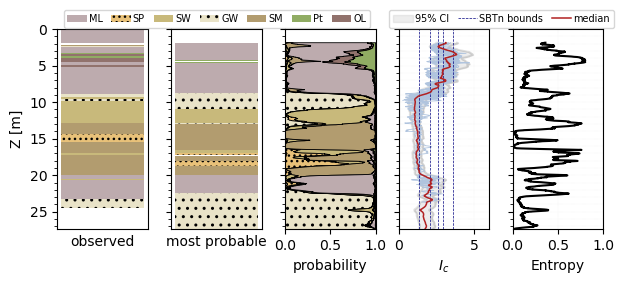

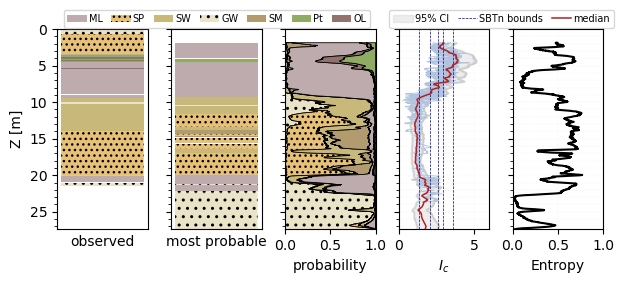

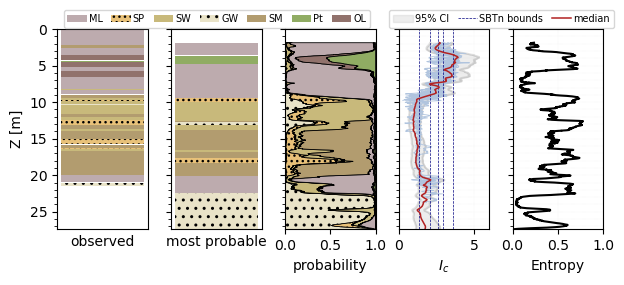

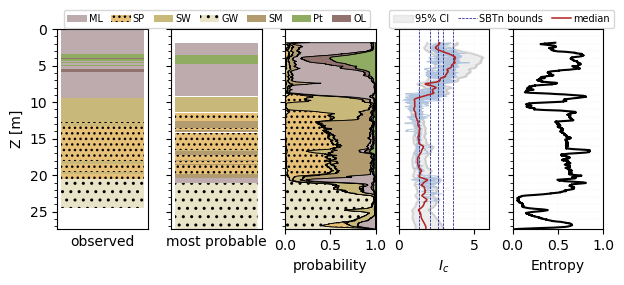

In [83]:
# =============================================================================
from matplotlib.ticker import AutoMinorLocator

hatches=['..','...','','','','','']
Rn = ['GW', 'SP', 'SW', 'SM', 'ML', 'OL', 'Pt']  # manual ordering accordieng to soil!
indx = []
for i,c in enumerate(Rn):
    indx.append(R.index(c))
    

# lithological plots
# SEE: https://towardsdatascience.com/displaying-lithology-data-using-python-and-matplotlib-58b4d251ee7a

lithology_colors = [(0.9137254901960784, 0.8895686274509804, 0.7843921568627451),      
                    (0.9090, 0.75640, 0.4750),              
                    (0.7843137254901961, 0.7239215686274509, 0.4835294117647059),
                    (0.6980392156862745, 0.6134901960784314, 0.4369411764705882),
                    (0.7411764705882353, 0.6687058823529413, 0.6831764705882354),
                    (0.5686274509803921, 0.4478431372549019, 0.4219607843137255), 
                    (0.5660, 0.6740, 0.3880)]


lithology_numbers = {'ML': {'name':'ML', 'lith_num':1, 'hatch': hatches[Rn.index("ML")], 'color':lithology_colors[Rn.index("ML")]},
                 'SP': {'name':'SP', 'lith_num':2, 'hatch': hatches[Rn.index("SP")], 'color':lithology_colors[Rn.index("SP")]},
                 'SW': {'name':'SW', 'lith_num':3, 'hatch': hatches[Rn.index("SW")], 'color':lithology_colors[Rn.index("SW")]},
                 'GW': {'name':'GW', 'lith_num':4, 'hatch':hatches[Rn.index("GW")], 'color':lithology_colors[Rn.index("GW")]},
                 'SM': {'name':'SM', 'lith_num':5, 'hatch':hatches[Rn.index("SM")], 'color':lithology_colors[Rn.index("SM")]},             
                 'Pt': {'name':'Pt', 'lith_num':11, 'hatch':hatches[Rn.index("Pt")], 'color':lithology_colors[Rn.index("Pt")]},
                 'OL': {'name':'OL', 'lith_num':12, 'hatch':hatches[Rn.index("OL")], 'color':lithology_colors[Rn.index("OL")]}}

# ==============================================================================
# Grid plot with most relevant profiles
# =============================================================================

                            
for loc in range(len(bhs)):      
    Pr_uscs = probabilities[loc].detach().T[indx]

    df = pd.DataFrame(data=max_probs[loc], columns = ["prob"])
    df["class"] =  most_prob_profile[loc]
    df["z"] = np.round(depth, 2)
    df["x"] = 2
    df["H_uscs"] = H[loc]
    df['class'] = df['class'].map(inv_map)                                      
                                          
    fig = plt.figure(figsize = (7.05, 2.6))

    gs = fig.add_gridspec(1, 5, hspace=0, wspace=0.255)
    (ax1, ax2, ax3, ax4, ax5) = gs.subplots(sharex='col', sharey='row')
    for key in lithology_numbers.keys():
        color = lithology_numbers[key]['color']
        hatch = lithology_numbers[key]['hatch']
        ax2.fill_betweenx(df['z'], 0, 1, where=(df['class']==key),
                              facecolor=color, hatch=hatch, label=key)
    
    for key in lithology_numbers.keys():
        color = lithology_numbers[key]['color']
        hatch = lithology_numbers[key]['hatch']
        ax1.fill_betweenx(df_test["z"], 0, 1, where=(df_test.iloc[:,loc]==key),
                             facecolor=color, hatch=hatch, label=key)
        
    polys = ax3.stackplot(df['z'], Pr_uscs,
                 labels=Rn,edgecolors="black", colors = lithology_colors, linewidth=0.6)
    xlims = ax3.get_xlim()
    xlims = (0, depth_max)
    ylims = ax3.get_ylim()
    for poly in polys:
        for path in poly.get_paths():
            path.vertices = path.vertices[:, ::-1]
            
    for stack, hatch in zip(polys, hatches):
        stack.set_hatch(hatch)

    ax3.set_xlim(ylims)  # use old y limits
    ax3.set_ylim(xlims[::-1])  # use old x limits, reversed

    ax4.plot(lower_Ic.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
            df['z'],
                      color = "black", alpha = 0.1)
    ax4.plot(upper_Ic.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
            df['z'],
                      color = "black", alpha = 0.1)
    ax4.fill_betweenx(df['z'], 
                      lower_Ic.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
                      upper_Ic.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
                      color = "darkgrey", alpha = 0.2, label='95% CI')# ax.set_xlim(0,5)
    for i, dat in enumerate(data_cpts.T):
        if i==0:  
            ax4.plot(np.exp(dat), zt*(Dz-1.86)+1.86, '-', 
                    color = "lightsteelblue", linewidth = 0.6) #, label='training data'
        else:
            ax4.plot(np.exp(dat), zt*(Dz-1.86)+1.86, '-', 
                    color = "lightsteelblue", linewidth = 0.6)       # To plot the traiining data
    for xc in bounds:
        if xc == bounds[0]:
            ax4.axvline(x=xc, linestyle = "dashed", color='navy', 
                    linewidth = 0.5, label = "SBTn bounds")
        else:
            ax4.axvline(x=xc, linestyle = "dashed", color='navy', 
                    linewidth = 0.5)
            
    ax4.plot(post_mean_ic.exp()[loc*nv_test:nv_test*(loc+1)], 
            df['z'], 
            '-', color='firebrick', linewidth = 1.1, label='median')        
    ax5.plot(H[loc], df['z'], color = "black")
    ax5.set_xlim(0,1)
    ax3.set_xlim(0,1)
    ax4.set_xlim(0,6.0)

    ax4.set_xlabel(r'$I_c$')
    ax4.legend(bbox_to_anchor=(2.42, 1.12), ncol=3, fontsize = 7, handletextpad=0.2, columnspacing=0.9)

    ax1.set_xlabel("observed")
    ax1.set_ylabel("Z [m]")
    ax2.set_xlabel("most probable")
    ax3.set_xlabel("probability")
    ax5.set_xlabel("Entropy")
    ax5.grid(which="both", color="darkgrey", alpha=.3, linewidth=0.25,linestyle=":")
    ax5.grid(which="both", color="darkgrey", alpha=.3, linewidth=0.25,linestyle=":")
    ax4.grid(which="both", color="darkgrey", alpha=.3, linewidth=0.25,linestyle=":")
    ax4.grid(which="both", color="darkgrey", alpha=.3, linewidth=0.25,linestyle=":")
    ax5.invert_yaxis() 
    ax4.invert_yaxis() 
    ax3.invert_yaxis() 
    ax2.invert_yaxis() 
    ax2.set_xticks([])  
    ax1.set_xticks([])  
    ax1.yaxis.set_minor_locator(AutoMinorLocator())
    ax1.legend(bbox_to_anchor=(3.5, 1.12), ncol = num_classes, fontsize = 7,handletextpad=0.2, columnspacing=0.9)

    fig.show()    

# for i in range(2):
#     print(model.covar_module.base_kernel.kernels[i].lengthscale.cpu().detach() )
# model.covar_module.base_kernel.kernels[1].lengthscale 

In [84]:
# Classification metrics

encoded_classes = np.array(encoded_classes, dtype = float)
encoded_classes[encoded_classes == np.max(encoded_classes)] = np.nan


test_classes_bh_num = encoded_classes[:, [8, 0, 4, 2]]
y_test = test_classes_bh_num.T.ravel()
y_test = y_test[~np.isnan(y_test)]
y_vec_test = y_test.astype(int)
y_discrete_test = torch.tensor(y_vec_test).long()
classes_test = np.unique(y_vec_test)
num_classes = len(classes)
Y_test = np.zeros((len(y_vec_test), len(classes_test)))
#Y_pred = np.zeros((len(y_vec_test), len(classes_test)))

for i, e in enumerate(y_vec_test):
    Y_test[i, np.where(classes_test == e)[0]] = 1


In [85]:
def cross_entropy(targets, predictions,  epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

test_loc 0
cross entropy skl 1.1016071204615672
cross entropy manual 1.1439254493032092

accuracy score:  0.6954404603806994

precision score:  0.6937366111537296
------------------------------------
test_loc 1
cross entropy skl 1.3677043827767337
cross entropy manual 1.4165033597305166

accuracy score:  0.6513527309851965

precision score:  0.6924633600335086
------------------------------------
test_loc 2
cross entropy skl 0.9703656259043304
cross entropy manual 1.0191646086631105

accuracy score:  0.6467585502807555

precision score:  0.6523755101539449
------------------------------------
test_loc 3
cross entropy skl 1.340680932048461
cross entropy manual 1.3829992566506728

accuracy score:  0.7149181053563524

precision score:  0.8214693147487931
------------------------------------

accuracy score total:  0.679113323850166

precision score total:  0.685247249016121
cross entropy skl total 1.1969426099604505


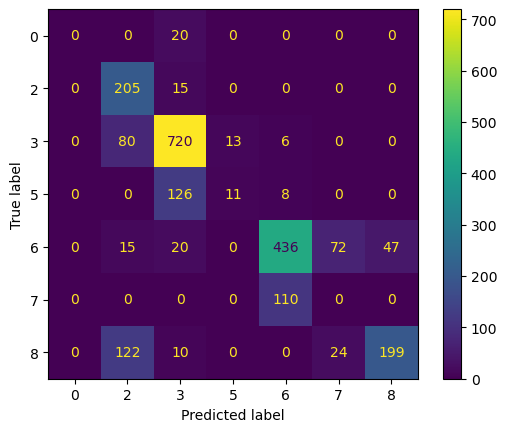

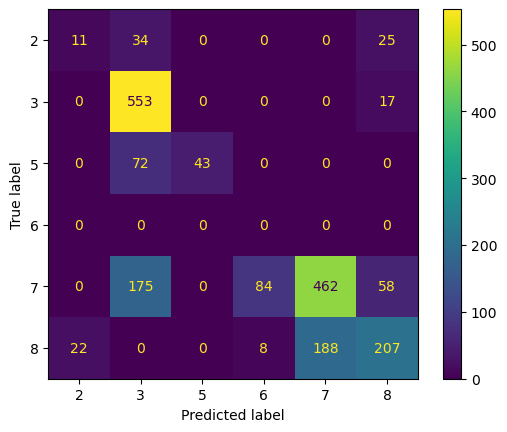

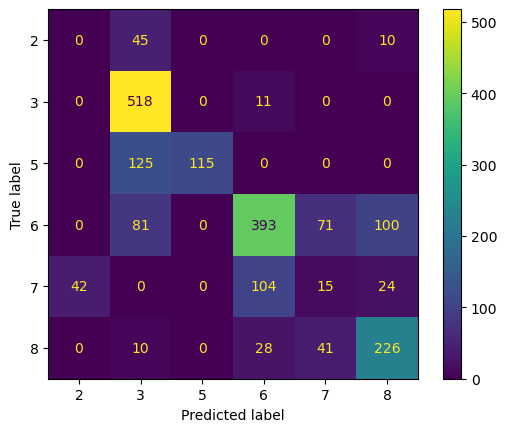

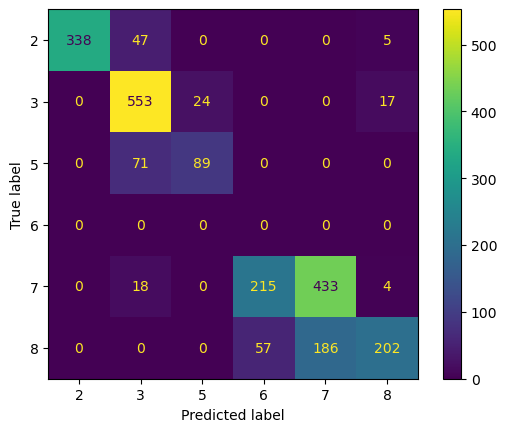

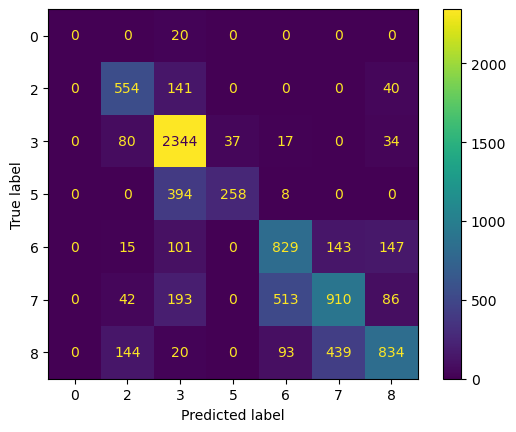

In [86]:
# The number of nonnan elements in each testing borehole
bhi_test_num_el = (np.ones(4)*len(encoded_classes) - np.isnan(encoded_classes[:, [8, 0, 4, 2]]).sum(axis=0)).astype(int)

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score, roc_auc_score, log_loss

from collections import defaultdict
dict_metrics_bh = {i: defaultdict(list) for i in range(len(bhs))}

y_true=[]; y_pred=[]; targets = []; inputs = [] #to test entire set of bhs
for loc in range(len(bhs)):   

    z_bh = df_test["z"][:bhi_test_num_el[loc]]
    dict_metrics_bh[loc]["z_bh"]=(df_test["z"][:bhi_test_num_el[loc]])
    dict_metrics_bh[loc]["y_test_bh"]=( torch.tensor(Y_test[:bhi_test_num_el[loc], :][np.where(z_bh>=1.86)] ))

   # y_test_cat_bh[y_test_cat_bh==5] = 4
    dict_metrics_bh[loc]["y_test_bh_cat"]=np.array(encoded_classes[:, [8, 0, 4, 2]][np.where(z_bh>=1.86)] [:, loc], dtype=int)
   
#    #===========================================
#     #merge OL and Pt (only for prediction); consider merging them from the beginning since it doesn't really matter
    dict_metrics_bh[loc]["y_test_bh_cat"][dict_metrics_bh[loc]["y_test_bh_cat"]==4] = 5
#    #===========================================
    pred_probs_bh =  probabilities[loc][np.where(depth<=max(z_bh))]
    z_bh = z_bh[z_bh>=1.86]

    pred_probs_bh = torch.cat([torch.zeros(len(pred_probs_bh), 2), pred_probs_bh], -1).clone().detach().requires_grad_(True)
    pred_class = np.array(most_prob_profile[loc][np.where(depth<=max(z_bh))],dtype=int)
    dict_metrics_bh[loc]["pred_probs_bh"] = pred_probs_bh
    dict_metrics_bh[loc]["pred_class_bh"] = pred_class

    input = dict_metrics_bh[loc]["pred_probs_bh"]
    target = dict_metrics_bh[loc]["y_test_bh"]
    
    print("test_loc", loc)

    targets.append(target.numpy()); inputs.append(input.detach())
    print("cross entropy skl", log_loss( target.numpy(), input.detach().numpy()))
    print("cross entropy manual", cross_entropy( target.numpy(), input.detach().numpy()))
    
    print("\naccuracy score: ",  accuracy_score(dict_metrics_bh[loc]["y_test_bh_cat"], 
                                                     dict_metrics_bh[loc]["pred_class_bh"]))
    
    print("\nprecision score: ",  precision_score(dict_metrics_bh[loc]["y_test_bh_cat"], 
                                                     dict_metrics_bh[loc]["pred_class_bh"], average = "weighted", zero_division = 0.0 ))
    
    ConfusionMatrixDisplay.from_predictions(dict_metrics_bh[loc]["y_test_bh_cat"],
                                            dict_metrics_bh[loc]["pred_class_bh"],
                                           )
    
    print("------------------------------------")
    y_true.append(dict_metrics_bh[loc]["y_test_bh_cat"])
    y_pred.append(dict_metrics_bh[loc]["pred_class_bh"])


    
print("\naccuracy score total: ",  accuracy_score(np.concatenate(y_true), 
                                                    np.concatenate(y_pred)
                                                  ))
print("\nprecision score total: ",  precision_score(np.concatenate(y_true), 
                                                    np.concatenate(y_pred), 
                                                  average = "weighted", zero_division = 0.0 ))
print("cross entropy skl total", log_loss( np.concatenate(targets), np.concatenate(inputs)))

ConfusionMatrixDisplay.from_predictions(np.concatenate(y_true),
                                        np.concatenate(y_pred),
                                        #display_labels=np.sort(pd.Series(dict_metrics_bh[loc]["y_test_bh_cat"]).map(inv_map).unique().tolist())     
                                        )



In [95]:
# Predictions at the test CPT locations
Dz = np.max(z_mat) 

# [85.4000 131.3500 147.1300 171.2800 200.2800] m
# [72.8800 56.1300 28.7800 53.5600 55.3000] m

x_p_m = np.array(xt_test)    # CPT_2, CPT_11, CPT_18, CPT_13, CPT_14
y_p_m = np.array(yt_test)
nv_test = 2745 - int(1.86/0.01) + 1


zt_test = zt
nv_test = len(zt_test)

nh_test = (x_p_m).shape[0]
n_uscs_samples = 400

z_t = zt_test
x_t = x_p_m
y_t = y_p_m

n_v = (z_t).shape[0]
n_h = (x_t).shape[0]

N = n_v * n_h


grid_test = [torch.from_numpy(z_t), 
             torch.from_numpy(x_t), 
             torch.from_numpy(y_t)]


test_zx = gpytorch.utils.grid.create_data_from_grid([grid_test[0], grid_test[1]])
test_zy = gpytorch.utils.grid.create_data_from_grid([grid_test[0], grid_test[2]])
test_x = torch.stack([test_zx[:,0].view(-1,1), 
                       test_zx[:,1].view(-1,1), 
                       test_zy[:,1].view(-1,1)]).squeeze().t().to(train_X)

In [88]:
test_dataset = TensorDataset(test_x, test_x)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle=False)



model.eval()
#likelihood = FixedNoiseGaussianLikelihood(noise=train_Yvar.squeeze(-1)).to(device)
likelihood.eval()

means = []; lower = []; upper = []; std = []
probs_batched = []
#pred_samples_batched = []
with torch.no_grad(), gpytorch.settings.fast_pred_var(True), gpytorch.settings.fast_computations(
        covar_root_decomposition=False,  solves=False),\
    gpytorch.settings.use_toeplitz(False):
        for x_batch_t,_ in test_loader:
            num = len(torch.unique(x_batch_t[:,0]))
            #predictions = likelihood(model(x_batch_t, output_indices=[len(classes)]))
            predictions = likelihood(model(x_batch_t))
            means.append(predictions.mean.cpu())
            l, u = predictions.confidence_region()
            lower.append(l)
            upper.append(u)
            std.append(predictions.variance.sqrt().cpu())
            #samples_uscs = model.posterior(x_batch_t, output_indices=[i for i in range(len(classes))]).sample(torch.Size((100,)))
            samples_uscs = predictions.sample(torch.Size((400,)))
            pred_samples_uscs = samples_uscs.exp()[:,..., :len(classes)]    
            #pred_samples_batched.append(pred_samples_uscs)
            probs_batched.append((pred_samples_uscs / pred_samples_uscs.sum(-1, keepdim=True)).mean(0))


C:\Users\ozinas\.conda\envs\spyder-cuda\Lib\site-packages\gpytorch\likelihoods\gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


In [89]:
mean = torch.concat([means[i] for i in range(len(means))], dim=0)
lower = torch.concat([lower[i] for i in range(len(lower))], dim=0)
upper = torch.concat([upper[i] for i in range(len(upper))], dim=0)
#probabilities = torch.concat([probs_batched[i] for i in range(len(probs_batched))], dim=0)[:,:len(classes)]
probabilities = torch.cat([probs_batched[i] for i in range(len(probs_batched))], dim=0)[:,:len(classes)].reshape(nh_test,nv_test,num_classes).cpu()
stdev = torch.concat([std[i] for i in range(len(std))], dim=0)

In [90]:
probabilities = torch.cat([probs_batched[i] for i in range(len(probs_batched))], dim=0)[:,:len(classes)].reshape(nh_test,nv_test,num_classes).cpu()
post_median_Ic = (mean[..., -2].cpu()  * std_Ic_log + mu_Ic_log)   

lower_Ic = lower[..., -2].cpu() * std_Ic_log + mu_Ic_log        
upper_Ic = upper[..., -2].cpu() * std_Ic_log + mu_Ic_log  


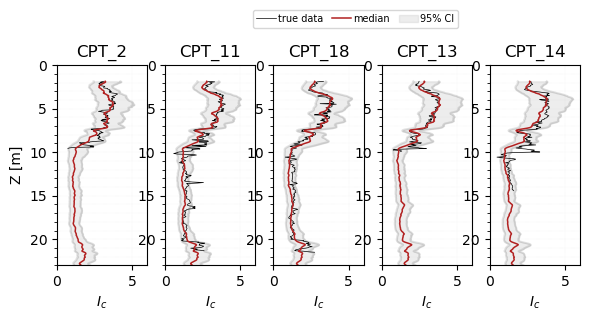

In [91]:
# =============================================================================
# Plots of Ic pred at test locations (cpt)
# =============================================================================
depth = z_t * (Dz-depth_0) + depth_0       
#depth = z_t * (depth_max-depth_0) + depth_0       
cpt_locs = ["CPT_2", "CPT_11", "CPT_18", "CPT_13", "CPT_14"]   # with respect to x (see excel file)
#depth = z_t_m 

post_mean_ic = mean[..., -1].cpu()  * std_Ic_log + mu_Ic_log         
lower_Ic = lower[..., -1].cpu() * std_Ic_log + mu_Ic_log        
upper_Ic = upper[..., -1].cpu() * std_Ic_log + mu_Ic_log      
par = "Ic"
# =============================================================================
# Plots
# =============================================================================
bounds = [1.31, 2.05, 2.6, 2.95, 3.6]
from matplotlib.ticker import AutoMinorLocator
task_names = [r'$I_c$']
fig, axs = plt.subplots(1, (x_t).shape[0], figsize = (6.75, 2.6))
for i, ax in enumerate(axs):
    cut_id = i
    ax.plot(np.exp(data_test[:, cut_id]), (depth), '-', color='black', linewidth = 0.5, label='true data')
    ax.plot(post_mean_ic.exp().reshape(n_h, n_v).T[:, cut_id], 
            (depth), 
            '-', color='firebrick', linewidth = 1.1, label='median')
    # Shade in confidence
    ax.fill_betweenx( (depth), upper_Ic.exp().reshape(n_h, n_v).T[:, cut_id], 
    lower_Ic.exp().reshape(n_h, n_v).T[:, cut_id], 
    color = "darkgrey", alpha = 0.2 , label='95% CI')  


    ax.plot(upper_Ic.exp().reshape(n_h, n_v).T[:, cut_id],(depth), 
                      color = "black", alpha = 0.1)
    ax.plot(lower_Ic.exp().reshape(n_h, n_v).T[:, cut_id],(depth), 
                      color = "black", alpha = 0.1)
   
    ax.yaxis.set_minor_locator(AutoMinorLocator())
        
    ax.grid(which="both", color="darkgrey", alpha=.3, linewidth=0.25,linestyle=":")
    
    ax.set_xlabel(task_names[0])
    ax.set_ylim(0,23)
    #ax.set_xticks(np.arange(0,6,2))  
    ax.set_xlim(0,6.0)
    if i==0:
        ax.legend()
        ax.set_ylabel('Z [m]')
        #ax.set_xlim(0,3)
        ax.legend(bbox_to_anchor=(4.5, 1.3), ncol = num_classes, fontsize = 7,handletextpad=0.2, columnspacing=0.9)
    ax.set_title(cpt_locs[i])
    ax.invert_yaxis()


In [92]:
# Correct way
test_y = torch.tensor(np.ravel(data_test, order="f"), dtype= dtype,device="cpu")
test_ylog = torch.tensor(np.ravel(data_test, order="f"), dtype= dtype,device=device)

idnan = torch.isnan(test_y)

mean_logIc_u_star = mean[:, -1][~idnan.cpu()]
std_logIc_u_star = stdev[:, -1][~idnan.cpu()]
cov_logIc_u_star = torch.eye(len(mean_logIc_u_star)) * std_logIc_u_star**2

mean_logIc_n_star = mean_logIc_u_star*std_Ic_log + mu_Ic_log  # of logIc
std_logIc_n_star = np.sqrt(std_Ic_log**2 * std_logIc_u_star**2)   # of logic

pred_dist = gpytorch.distributions.MultivariateNormal(mean_logIc_n_star,  torch.eye(len(mean_logIc_n_star)) * std_logIc_n_star**2)

nlpd1 = gpytorch.metrics.negative_log_predictive_density(pred_dist,
                                                            test_ylog.cpu()[~idnan.cpu()])
msll = gpytorch.metrics.mean_standardized_log_loss(pred_dist,
                                                            test_y[~idnan.cpu()])

dist = torch.distributions.Normal(mean_logIc_n_star, std_logIc_n_star)
ce_man = -dist.log_prob(test_y[~idnan.cpu()]).sum() / len(test_ylog.cpu()[~idnan.cpu()])
# ce_man = (0.5 * torch.log(2 * np.pi * std_logIc_n_star**2) + \
#           torch.square(test_y[~idnan] - mean_logIc_n_star) / (2 * std_logIc_n_star**2)).sum() / len(test_y[~idnan])

print("average cross entropy loss = ", nlpd1.item())
print("average cross entropy loss (man.) = ", ce_man.item())

print("mean std loss = ", msll.item())


loss_fn = torch.nn.MSELoss()
RMSE_loss = torch.sqrt(loss_fn(mean_logIc_n_star,  test_y[~idnan.cpu()]))
#RMSE_loss.backward()
print("RMSE Ic = ", RMSE_loss)


average cross entropy loss =  -0.28295403718948364
average cross entropy loss (man.) =  -0.2829541265964508
mean std loss =  -0.2829541265964508
RMSE Ic =  tensor(0.1959)


In [93]:
most_prob_profile = np.empty((nh_test, nv_test))
max_probs = np.empty((nh_test, nv_test))
H = np.empty((nh_test, nv_test))

for i, probs in enumerate(probabilities):
    most_prob_profile[i], max_probs[i], H[i] = most_probable_uscs(probs, mapping, inv_map)

C:\Users\ozinas\AppData\Local\Temp\ipykernel_9976\4278156010.py:82: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\ozinas\AppData\Local\Temp\ipykernel_9976\4278156010.py:82: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\ozinas\AppData\Local\Temp\ipykernel_9976\4278156010.py:82: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\ozinas\AppData\Local\Temp\ipykernel_9976\4278156010.py:82: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\ozinas\AppData\Local\Temp\ipykernel_9976\4278156010.py:82: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


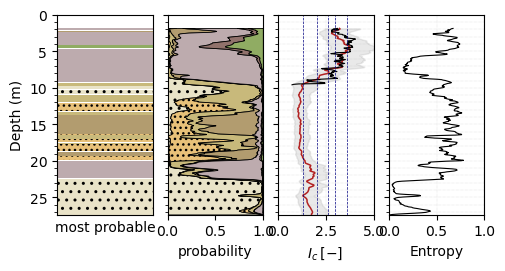

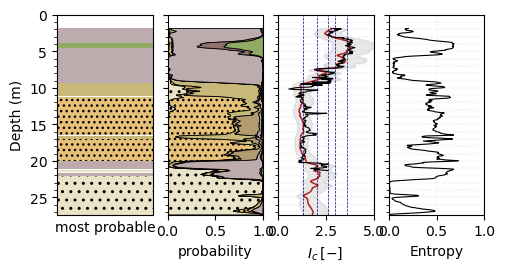

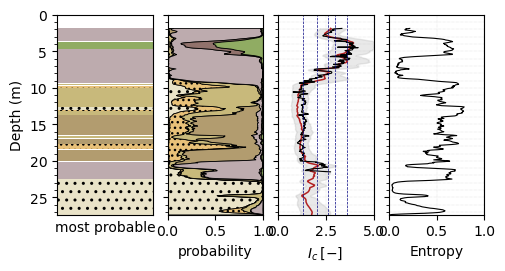

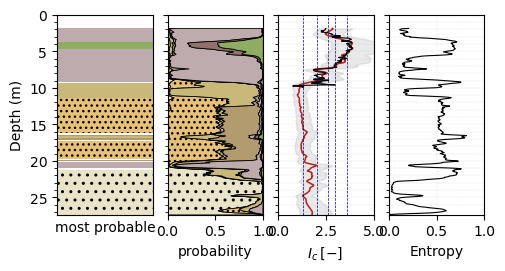

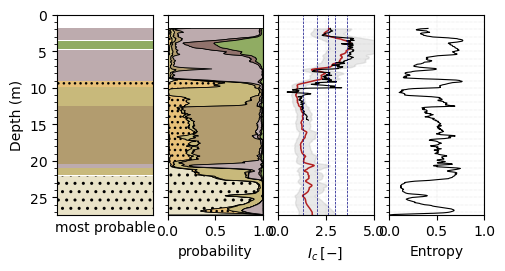

In [94]:
# ==============================================================================
# Grid plot with most relevant profiles
# =============================================================================
                            
for loc in range(len(cpt_locs)):      
    Pr_uscs = probabilities[loc].detach().T[indx]

    df = pd.DataFrame(data=max_probs[loc], columns = ["prob"])
    df["class"] =  most_prob_profile[loc]
    df["z"] = np.round(depth, 2)
    df["x"] = 2
    df["H_uscs"] = H[loc]
    df['class'] = df['class'].map(inv_map)                                      
                                          
    fig = plt.figure(figsize = ((9.11+4.9)/2.54, 6.6/2.54))
    gs = fig.add_gridspec(1, 4, hspace=0, wspace=0.155)
    (ax1, ax2, ax3, ax4) = gs.subplots(sharex='col', sharey='row')

    for key in lithology_numbers.keys():
        color = lithology_numbers[key]['color']
        hatch = lithology_numbers[key]['hatch']
        ax1.fill_betweenx(df['z'], 0, 1, where=(df['class']==key),
                              facecolor=color, hatch=hatch, label=key)
    polys = ax2.stackplot(df['z'], Pr_uscs,
                 labels=Rn,edgecolors="black", colors = lithology_colors, linewidth=0.6)
    xlims = ax2.get_xlim()
    xlims = (0, depth_max)
    ylims = ax2.get_ylim()
    for poly in polys:
        for path in poly.get_paths():
            path.vertices = path.vertices[:, ::-1]
            
    for stack, hatch in zip(polys, hatches):
        stack.set_hatch(hatch)

    ax2.set_xlim(ylims)  # use old y limits
    ax2.set_ylim(xlims[::-1])  # use old x limits, reversed
    
    ax3.plot(post_mean_ic.exp()[loc*nv_test:nv_test*(loc+1)], 
            df['z'], '-', color='firebrick', linewidth = 1.1)
    
    ax3.plot(np.exp(data_test[:, loc]), 
            depth, '-', color='black', linewidth = 0.8)

    # Shade in confidence
    ax3.fill_betweenx( depth, upper_Ic.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
    lower_Ic.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
    color = "darkgrey", alpha = 0.25 , label='95% confidence')     
    
    for xc in bounds:
        if xc == bounds[0]:
            ax3.axvline(x=xc, linestyle = "dashed", color='navy', 
                    linewidth = 0.5, label = "SBTn bounds")
        else:
            ax3.axvline(x=xc, linestyle = "dashed", color='navy', 
                    linewidth = 0.5, label = "SBTn bounds")
    # -----------------------------------------------------------------------------------------------------------
    ax4.plot(H[loc], df['z'], color = "black", linewidth = 0.8)
    # -----------------------------------------------------------------------------------------------------------

    ax4.grid(which="both", color="darkgrey", alpha=.6, linewidth=0.35,linestyle=":")
    ax3.grid(which="both", color="darkgrey", alpha=.6, linewidth=0.35,linestyle=":")
    ax1.set_xlim(0,1)
    ax2.set_xlim(0,1)
    ax4.set_xlim(0,1)
    ax3.set_xlim(0,5)


    ax3.set_xlabel(r'$I_c\:[-]$ ')
    ax1.set_ylabel("Depth (m)")
    ax1.set_xlabel("most probable")
    ax2.set_xlabel("probability")
    ax4.set_xlabel("Entropy")

    ax4.invert_yaxis() 
    ax3.invert_yaxis() 
    ax2.invert_yaxis()
    ax1.invert_yaxis() 
    
    ax1.set_xticks([])  
    ax1.yaxis.set_minor_locator(AutoMinorLocator())
    fig.show()      